# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

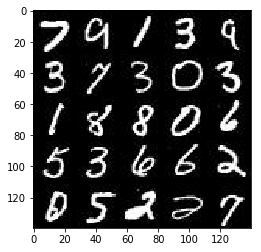

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

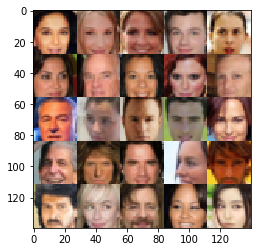

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
            
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
     
        x2 = tf.layers.conv2d_transpose(x1, 128, 1, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
       
        x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
       
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate*2, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr:learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.4853... Generator Loss: 0.0581
Epoch 1/2... Discriminator Loss: 2.3834... Generator Loss: 8.6953
Epoch 1/2... Discriminator Loss: 0.9804... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.4635
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 1.3608
Epoch 1/2... Discriminator Loss: 2.4032... Generator Loss: 0.1255
Epoch 1/2... Discriminator Loss: 1.9215... Generator Loss: 2.9014
Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 1.7733
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.4936
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 4.2876


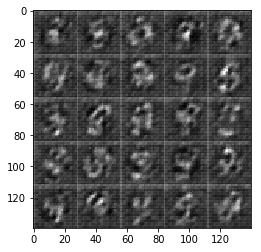

Epoch 1/2... Discriminator Loss: 0.4307... Generator Loss: 1.4691
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 1.1053
Epoch 1/2... Discriminator Loss: 0.4793... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 7.9440... Generator Loss: 0.0006
Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 1.6389... Generator Loss: 0.4946
Epoch 1/2... Discriminator Loss: 1.7311... Generator Loss: 0.2719
Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 1.4754
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.5862
Epoch 1/2... Discriminator Loss: 0.6109... Generator Loss: 1.3752


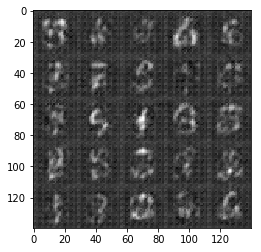

Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 0.5558
Epoch 1/2... Discriminator Loss: 0.6543... Generator Loss: 1.2937
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 3.7889
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 1.4340
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 0.9068
Epoch 1/2... Discriminator Loss: 0.7035... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 0.4065... Generator Loss: 1.5473
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 2.0416


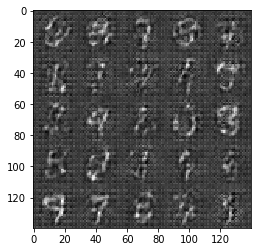

Epoch 1/2... Discriminator Loss: 0.6502... Generator Loss: 1.1003
Epoch 1/2... Discriminator Loss: 0.5557... Generator Loss: 1.1515
Epoch 1/2... Discriminator Loss: 3.9801... Generator Loss: 5.4724
Epoch 1/2... Discriminator Loss: 0.8225... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 0.7824
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 1.6537
Epoch 1/2... Discriminator Loss: 0.3228... Generator Loss: 3.1887
Epoch 1/2... Discriminator Loss: 1.5850... Generator Loss: 0.3579
Epoch 1/2... Discriminator Loss: 0.4713... Generator Loss: 1.5249
Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 1.1802


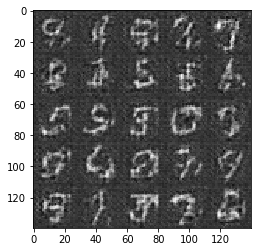

Epoch 1/2... Discriminator Loss: 0.4137... Generator Loss: 1.7193
Epoch 1/2... Discriminator Loss: 0.3391... Generator Loss: 1.6317
Epoch 1/2... Discriminator Loss: 0.3280... Generator Loss: 1.7381
Epoch 1/2... Discriminator Loss: 4.4047... Generator Loss: 5.4302
Epoch 1/2... Discriminator Loss: 0.7947... Generator Loss: 0.9606
Epoch 1/2... Discriminator Loss: 0.1749... Generator Loss: 2.6246
Epoch 2/2... Discriminator Loss: 0.1919... Generator Loss: 3.4631
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 4.0063
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 1.5847
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 1.4500


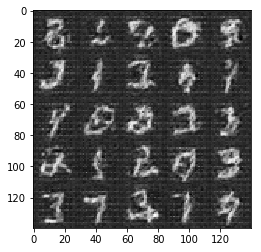

Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 1.9736
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 0.6654
Epoch 2/2... Discriminator Loss: 0.2401... Generator Loss: 2.3195
Epoch 2/2... Discriminator Loss: 0.1864... Generator Loss: 2.2045
Epoch 2/2... Discriminator Loss: 0.3280... Generator Loss: 1.7827
Epoch 2/2... Discriminator Loss: 0.4514... Generator Loss: 1.3161
Epoch 2/2... Discriminator Loss: 0.0530... Generator Loss: 4.8065
Epoch 2/2... Discriminator Loss: 0.2482... Generator Loss: 1.8683
Epoch 2/2... Discriminator Loss: 0.1522... Generator Loss: 2.3711
Epoch 2/2... Discriminator Loss: 0.0359... Generator Loss: 4.7123


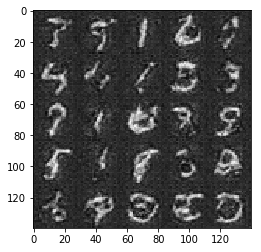

Epoch 2/2... Discriminator Loss: 0.0321... Generator Loss: 5.3767
Epoch 2/2... Discriminator Loss: 0.1356... Generator Loss: 3.8386
Epoch 2/2... Discriminator Loss: 4.6850... Generator Loss: 6.2565
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.7971
Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 1.6861
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 1.6258
Epoch 2/2... Discriminator Loss: 1.6302... Generator Loss: 2.5661
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 1.6102


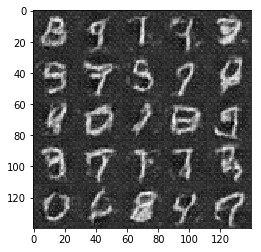

Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 0.9288
Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 1.5688
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.0836
Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 1.1710
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.4668
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 2.9305
Epoch 2/2... Discriminator Loss: 0.6874... Generator Loss: 1.4411
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 2.1895


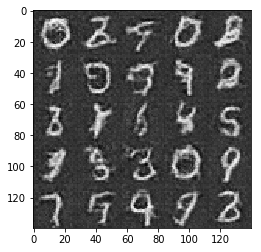

Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 2.4452
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 0.8318
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 2.6697
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 1.8222
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 2.3467
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.9158
Epoch 2/2... Discriminator Loss: 1.6283... Generator Loss: 0.3719
Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 1.7849
Epoch 2/2... Discriminator Loss: 2.3659... Generator Loss: 0.1526
Epoch 2/2... Discriminator Loss: 0.6384... Generator Loss: 1.0742


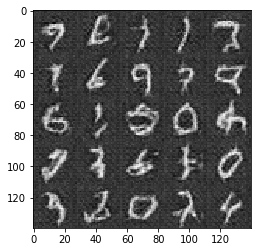

Epoch 2/2... Discriminator Loss: 0.2126... Generator Loss: 2.1558
Epoch 2/2... Discriminator Loss: 0.1366... Generator Loss: 2.5795
Epoch 2/2... Discriminator Loss: 1.7242... Generator Loss: 0.2697


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.4122... Generator Loss: 12.0086
Epoch 1/1... Discriminator Loss: 2.5398... Generator Loss: 0.2447
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 2.9681
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.6403
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 2.4985


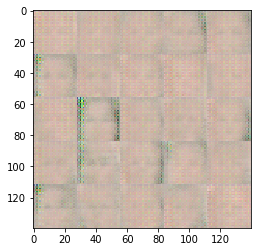

Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.1149
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 2.1725... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.7475


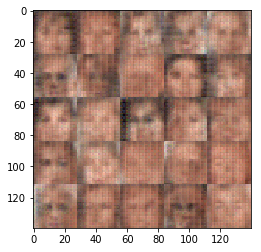

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 1.7629... Generator Loss: 1.5449
Epoch 1/1... Discriminator Loss: 1.6918... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.9641... Generator Loss: 2.6319
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.5019


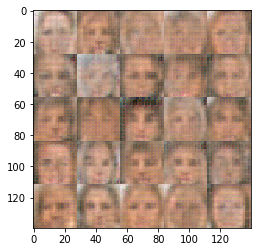

Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.2704
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.2647
Epoch 1/1... Discriminator Loss: 0.2919... Generator Loss: 2.5430
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.7098... Generator Loss: 0.2711
Epoch 1/1... Discriminator Loss: 2.0215... Generator Loss: 0.2092
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.8578


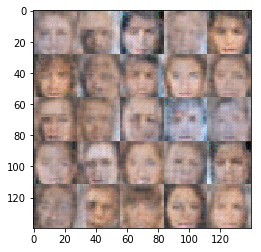

Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 1.7897
Epoch 1/1... Discriminator Loss: 2.2782... Generator Loss: 0.1347
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.5621
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.8905... Generator Loss: 0.4474
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.6768


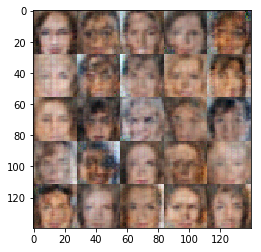

Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 2.6301... Generator Loss: 2.5019
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 2.5751... Generator Loss: 2.2503
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.6422


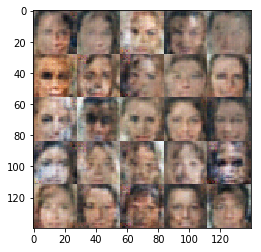

Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.9952


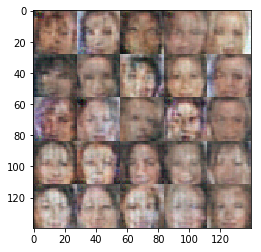

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.1873


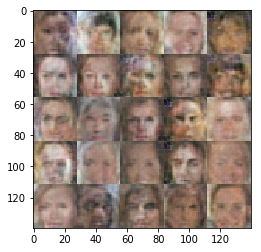

Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.7960... Generator Loss: 0.2610
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.9059


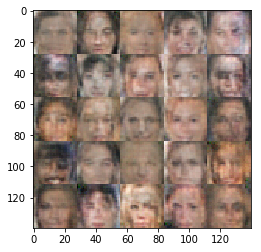

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.7580... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.5392


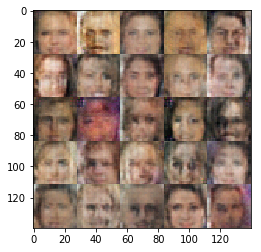

Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.7207


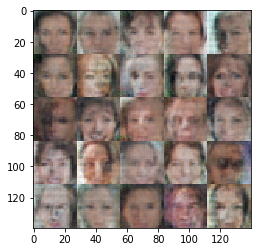

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.2614
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9353


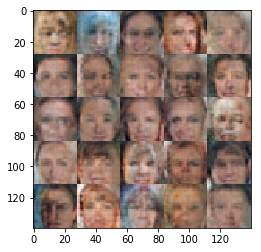

Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 1.1720
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 1.6942... Generator Loss: 0.3156


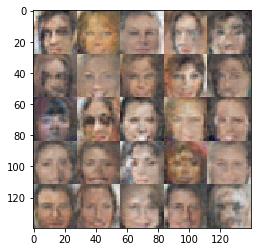

Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 2.3620
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 1.5898
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.5519


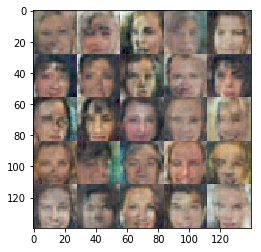

Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.3229
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 1.3223
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.7323


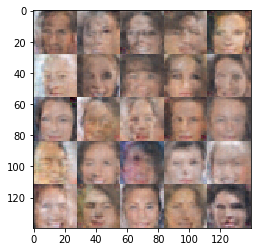

Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.1398... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.3464
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 1.4444
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.3820


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.